In [1]:
# Взято за основу отсюда: https://github.com/Intelligent-Systems-Phystech/StartCode/blob/master/Loginov2019Problem12/LinearRegressionAdditional/LinearRegressionError.ipynb
from tqdm import  *
import numpy as np
from sklearn import model_selection, datasets, linear_model, preprocessing, metrics
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

## Зависимость ошибки линейной регрессии от числа параметров модели

### Описание задания

Рассмотрим задачу, в которой есть следующие данные:

Матрица признаков объектов $X \in \mathbb{R}^{n \times d}$, где каждая строка - набор $d$ признаков объекта. Также для каждого объекта известно число $y_i$. Все они образуют вектор $y \in \mathbb{R}^n$. Задача: построить модель, отражающую зависимость $y$ от признаков.

Построим модель такого вида: $\widehat{y}(x) = x^\top \omega$, где $\omega \in \mathbb{R}$ - вектор весов параметров. Для измерения ошибки рассмотрим такую функцию:

$$ MSE(y, \widehat{y}) = \frac{1}{n}\sum\limits_{i=1}^n (y_i - \widehat{y}_i)^2 $$

Поиск $\omega_{opt} = \arg\min_\omega MSE(y, X\omega)$ будем производить на специально выделенной части данных - обучающей выборке - при помощи стохастического градиентного спуска. 

Исследуем зависимость ошибки линейной регрессии на тестовой выборке от количества параметров модели. Для этого воспользуемся сгенерированной синтетической выборкой. Сделаем значимыми примерно $\frac{2}{3}$ параметров. Также проверим теорему, утверждающую, что при использовании $L_1$-регуляризации незначимые признаки отбираются, то есть $\omega_i$ зануляется. Таким образом, будем оптимизировать по $\omega$ следующую функцию:

$$ L(y, \widehat{y}) = MSE(y, \widehat{y}) $$

Если свойство регуляризации верно, то можно  параметры для исследования в любом порядке, поскольку оптимальный набор параметр в любом случае когда-то встретится как подмножество.

В каждом случае, обучая модель, будем считать MSE на обучающей и тестовой выборке, строя несколько случайных разбиений. В конечном итоге будем иметь также дисперсию ошибки, а значит сможем построить доверительный интервал.

### Исходный код

In [91]:
"""Вычисляет интервалы для ошибки регрессии на тестовой и обучающей выборке.

    Для каждого префикса вектора параметров строит `n_splits` разбиений на обучение и контроль.
    Вычисляет среднее и дисперсию ошибки.
    Для построения интервала используется "правило 2 сигм"

    Parameters
    ----------
    X : array-like
        Матрица признаков объектов.
    y : array-like
        Вектор верных ответов.
    n_splits :
        Количество разбиений на обучение и контроль.
    
    Returns
    -------
    Матрица, каждая строка является списком из следующих элементов:
    левая граница интервала ошибки на обучении
    средняя ошибка на обучении
    правая граница интервала ошибки на обучении
    
    левая граница интервала ошибки на контроле
    средняя ошибка на контроле
    правая граница интервала ошибки на обучении
    """
def get_errors(X, y, n_splits = 30, use_model=linear_model.LinearRegression):
    res_matrix = []
    for i in tqdm(range(1, X.shape[1] + 1)):
        # выделим префиксы списка признаков
        data = X[:, :i]
        
        train_mse = []
        test_mse = []
        for split in range(n_splits):
            # разделим на train и test
            train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
                data, 
                y, 
                test_size = 0.4
            )
            # обучим модель
            model = use_model()
            model.fit(train_data, train_labels)
            train_predict = model.predict(train_data)
            test_predict = model.predict(test_data)
            # сохраним в список результаты
            train_mse.append(metrics.mean_squared_error(train_predict, train_labels))
            test_mse.append(metrics.mean_squared_error(test_predict, test_labels))
        
        # сформируем интервалы по правилу 2 сигм
        train_mean, train_sd = np.mean(train_mse), np.std(train_mse)
        test_mean, test_sd = np.mean(test_mse), np.std(test_mse)
        
        res = [train_mean - 2 * train_sd,
               train_mean,
               train_mean + 2 * train_sd,
               test_mean - 2 * test_sd,
               test_mean,
               test_mean + 2 * test_sd]
        res_matrix.append(res)
    return np.array(res_matrix)

In [105]:
"""Рисует графики ошибок, полученные функцией get_errors"""
def plot(xlim=None, ylim=None):
    plt.figure(figsize=(12, 7))
    grid = np.arange(1, X.shape[1] + 1)
    plt.plot(grid, errors[:, 1], color = 'red', label = 'train', lw = 2)
    plt.plot(grid, errors[:, 4], color = 'blue', label = 'test', lw = 2)

    plt.fill_between(grid, errors[:, 0], errors[:, 2], label = 'train interval', color = 'red', alpha = 0.2)
    plt.fill_between(grid, errors[:, 3], errors[:, 5], label = 'test interval', color = 'blue', alpha = 0.2)

    plt.xlabel('Количество признаков', fontsize = 15)
    plt.ylabel('MSE', fontsize = 15)
    plt.title('Зависимость ошибки от числа признаков', fontsize = 20)

    plt.grid()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(fontsize = 15)
    plt.show()

In [106]:
# сгенерируем данные
X, y = datasets.make_regression(
    n_samples = 150,
    n_features = 200,
    n_informative = 20, shuffle=False,
    noise = 1)

In [107]:
errors = get_errors(X, y, n_splits = 10)

100%|██████████| 200/200 [00:05<00:00, 24.30it/s]


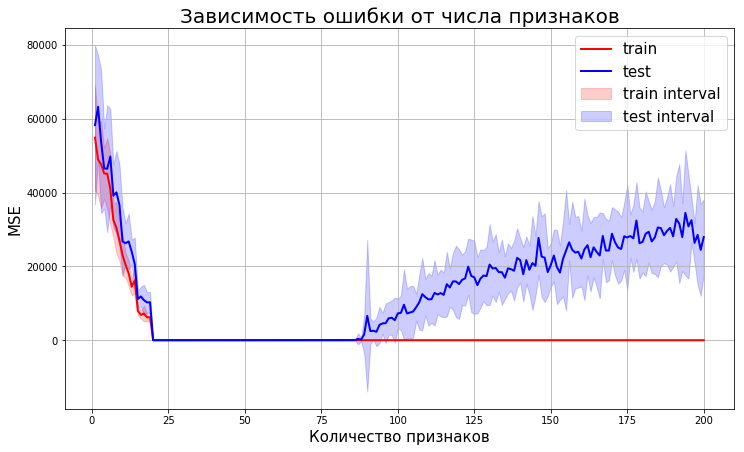

In [108]:
plot()

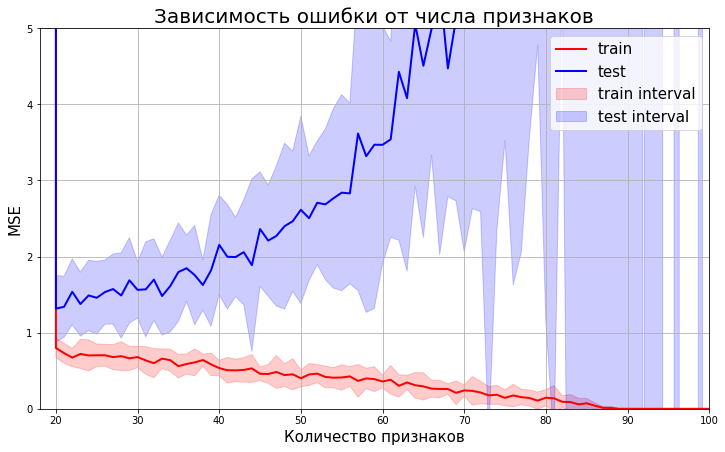

In [111]:
plot(xlim=(18, 100), ylim=(0, 5))

**Выводы:**

1) Видим, что пока модель обучается на информативных признаках, ошибка на train и на test падает и уже на 20 итерации, когда обучение происходит только на информативных признаках, мы получаем лучшее качество на тестовой выборке. 

2) Далее, добавляя неинформативные признаки, качество на обучающей выборке продолжает уменьшаться, так как эти признаки дают модели большую гибкость. Но эти зависимости не наблюдаются на тестовой выборке (ведь это шумовые признаки!), из-за чего качество на тесте начинает только расти. Начинается переобучение.

3) Уже когда шумовых признаков становится слишком много, равное кол-ву объектов в обучающей выборке. Ошибка на обучающей выборке становится абсолютным нулём (ведь признаков больше, чем объектов!), но на тестовой выборке начинает происходить полный.

* Шумовые признаки становятся серьёзной проблемой для модели обычной линейной регрессии. Даже на такой простой модели из-за таких признаков происходит переобучение: они помогают сделать ошибку на обучении меньше, но на тесте это не подтверждается. Поэтому очень важно использовать регуляризации, чтобы уменьшить эффект переобучения. 

## Регуляризация
Проверим как справятся с нашей задачей Линейные модели с регуляризацией

In [114]:
errors = get_errors(X, y, n_splits = 10, use_model=linear_model.Lasso)

100%|██████████| 200/200 [00:02<00:00, 68.53it/s] 


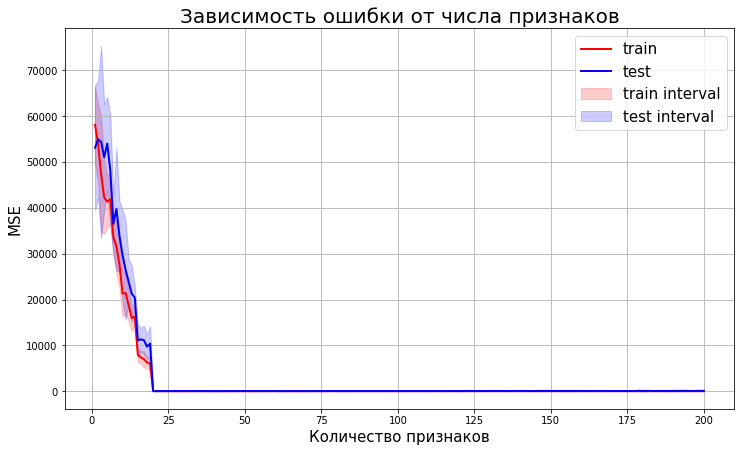

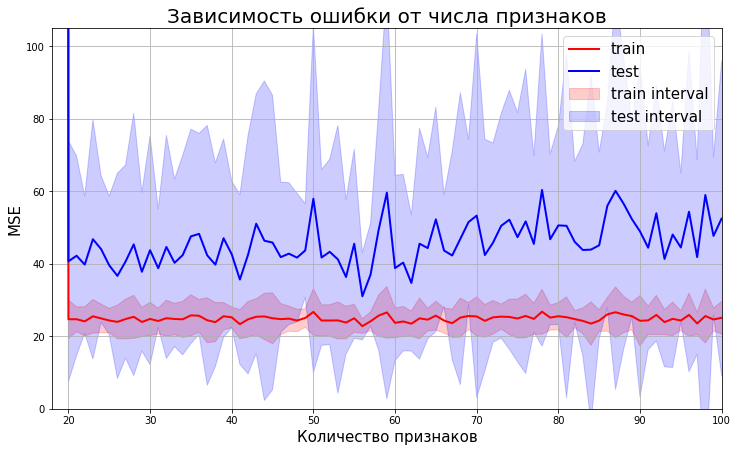

In [116]:
plot()
plot(xlim=(18, 100), ylim=(0, 105))

In [117]:
errors = get_errors(X, y, n_splits = 10, use_model=linear_model.Ridge)

100%|██████████| 200/200 [00:03<00:00, 65.33it/s]


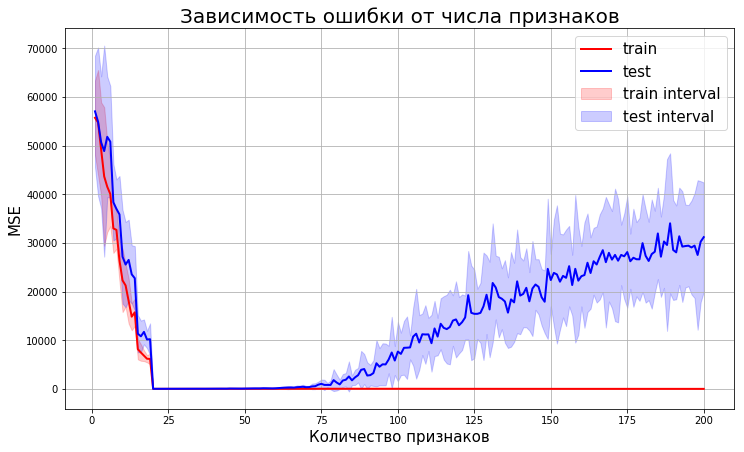

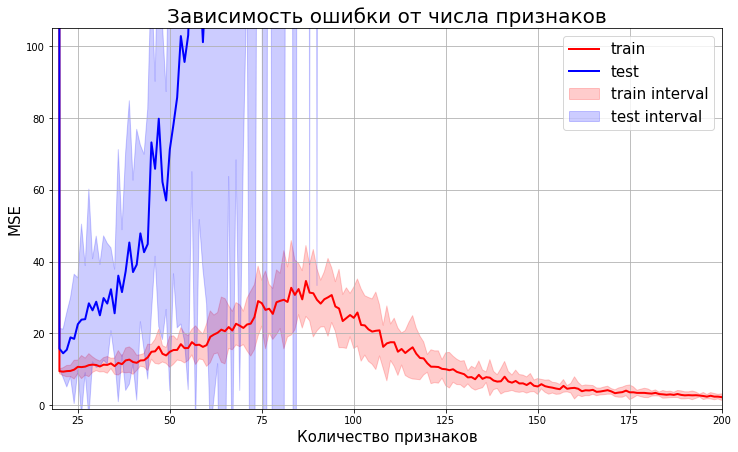

In [120]:
plot()
plot(xlim=(18, 200), ylim=(-1, 105))

Видим, что $L_2$ регуляризация не смогла справится с неинформативными признаками, в отличие от $L_1$. 

Вывод: Lasso лучше справляется с неинформативными признаками, полностью зануляя веса при них. В таких случая лучше использовать Lasso.